# Методы второго порядка

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from functions.functions_under_study import f_trend, predict
from functions.optimization import newton, gauss_newton, DFP, BFGS

In [9]:
method_names = [newton, gauss_newton, DFP, BFGS]
N_METH = len(method_names)

## Набор данных

Формируем синтетический датасет на основе полиномиальной функции с добавлением случайного шума ${\delta}$:

${f(x) = \sum_{k=0}^{K-1}{w_k \cdot x^k} + \delta}$,

где ${w}$ – массив весов размера ${K}$.

In [10]:
w_target = np.array([-5, 2, -3, 1, 0])
K = len(w_target)

x_min = 0
x_max = 3
N_points = 2000
# Случайный набор X-ов.
np.random.seed(42)
X_train = np.random.uniform(low=x_min, high=x_max, size=(N_points,))
X_train_vander = np.vander(X_train, K, increasing=True)
X_train_vander_plt = np.vander(np.sort(X_train), K, increasing=True)

# Отклики с добавлением шума.
y_train = f_trend(X_train) + np.random.normal(0,0.2,N_points)

In [11]:
user_figsize = (12, 6)
user_fontsize = 16
user_markersize = 12
line_style = ['-', '-.', '-', '-.']

<function matplotlib.pyplot.show(close=None, block=None)>

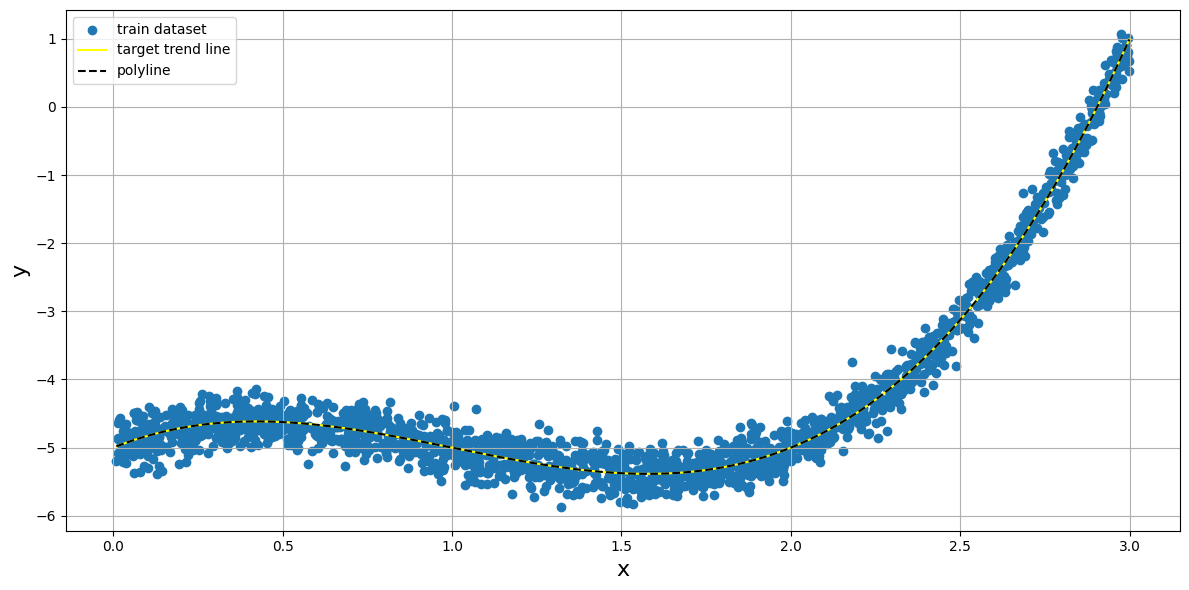

In [12]:
plt.figure(figsize=user_figsize)
plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), predict(X_train_vander_plt, w_target), '--', color='black')
plt.grid()
plt.legend(['train dataset', 'target trend line', 'polyline'])
plt.xlabel('x', fontsize=user_fontsize)
plt.ylabel('y', fontsize=user_fontsize)
plt.tight_layout()
plt.savefig('readme_img/dataset_plot.png', bbox_inches='tight')
plt.show

## Поиск оптимальных значений коэффициентов

In [13]:
N_EPS = 5
EPS_INIT = -1
eps_var = np.logspace(EPS_INIT, EPS_INIT-N_EPS+1, N_EPS)
print(eps_var)

[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]


In [14]:
w_optim_arr      = np.empty((N_METH,), dtype=object)
losses_arr       = np.empty((N_METH,), dtype=object)
iter_counter_arr = np.empty((N_METH,), dtype=object)
func_counter_arr = np.empty((N_METH,), dtype=object)
grad_counter_arr = np.empty((N_METH,), dtype=object)
hess_counter_arr = np.empty((N_METH,), dtype=object)
jacob_counter_arr = np.empty((N_METH,), dtype=object)

# Начальное приближение.
w_init = np.random.uniform(low=-10, high=10, size=(K,))

for mdx, meth in enumerate(method_names):
    w_optim_list        = []
    losses_list         = []
    iter_counter_list   = []
    func_counter_list   = []
    grad_counter_list   = []
    hess_counter_list   = []
    jacob_counter_list  = []
    
    for idx, eps in enumerate(eps_var):
        print(str(mdx*N_EPS + idx+1), 'of', str(N_METH*N_EPS) + ':', meth.__name__ + ', eps=' + str(eps), 'Processing...')
        w_optim, losses, iter_counter, func_counter, grad_counter, hess_counter, jacob_counter = meth(
            X_train_vander,
            y_train,
            w_init,
            tolerance=eps.copy()
            )
                        
        w_optim_list.append(w_optim)
        losses_list.append(losses)
        iter_counter_list.append(iter_counter)
        func_counter_list.append(func_counter)
        grad_counter_list.append(grad_counter)
        hess_counter_list.append(hess_counter)
        jacob_counter_list.append(jacob_counter)
        print('Done')
    
    w_optim_arr[mdx] = w_optim_list
    losses_arr[mdx] = losses_list
    iter_counter_arr[mdx] = iter_counter_list
    func_counter_arr[mdx] = func_counter_list
    grad_counter_arr[mdx] = grad_counter_list
    hess_counter_arr[mdx] = hess_counter_list
    jacob_counter_arr[mdx] = jacob_counter_list

1 of 20: newton, eps=0.1 Processing...
Done
2 of 20: newton, eps=0.01 Processing...
Done
3 of 20: newton, eps=0.001 Processing...
Done
4 of 20: newton, eps=0.0001 Processing...
Done
5 of 20: newton, eps=1e-05 Processing...
Done
6 of 20: gauss_newton, eps=0.1 Processing...
Done
7 of 20: gauss_newton, eps=0.01 Processing...
Done
8 of 20: gauss_newton, eps=0.001 Processing...
Done
9 of 20: gauss_newton, eps=0.0001 Processing...
Done
10 of 20: gauss_newton, eps=1e-05 Processing...
Done
11 of 20: DFP, eps=0.1 Processing...
Done
12 of 20: DFP, eps=0.01 Processing...
Done
13 of 20: DFP, eps=0.001 Processing...
Done
14 of 20: DFP, eps=0.0001 Processing...
Done
15 of 20: DFP, eps=1e-05 Processing...
Iteration 1828: Curvature condition violated (dw dgrad = 9.50e-11) resetting H_inv to identity.
Iteration 1829: Curvature condition violated (dw dgrad = 9.44e-11) resetting H_inv to identity.
Done
16 of 20: BFGS, eps=0.1 Processing...
Done
17 of 20: BFGS, eps=0.01 Processing...
Done
18 of 20: BFGS, 

Преобразуем в таблицы.

In [15]:
col_name = ['eps']
for mdx, meth in enumerate(method_names):
    col_name.append(meth.__name__)

iter_counter_tbl = eps_var.copy()
func_counter_tbl = eps_var.copy()
grad_counter_tbl = eps_var.copy()
hess_counter_tbl = eps_var.copy()
jacob_counter_tbl = eps_var.copy()

for col_iter, col_func, col_grad, col_hess, col_jacob in zip(
    iter_counter_arr,
    func_counter_arr,
    grad_counter_arr,
    hess_counter_arr,
    jacob_counter_arr
    ):
    
    iter_counter_tbl = np.vstack((iter_counter_tbl, col_iter))
    func_counter_tbl = np.vstack((func_counter_tbl, col_func))
    grad_counter_tbl = np.vstack((grad_counter_tbl, col_grad))
    hess_counter_tbl = np.vstack((hess_counter_tbl, col_hess))
    jacob_counter_tbl = np.vstack((jacob_counter_tbl, col_jacob))

iter_counter_tbl_set = pd.DataFrame(iter_counter_tbl.T, columns=col_name)
iter_counter_tbl_set[col_name[1:]] = iter_counter_tbl_set[col_name[1:]].astype(int)

func_counter_tbl_set = pd.DataFrame(func_counter_tbl.T, columns=col_name)
func_counter_tbl_set[col_name[1:]] = func_counter_tbl_set[col_name[1:]].astype(int)

grad_counter_tbl_set = pd.DataFrame(grad_counter_tbl.T, columns=col_name)
grad_counter_tbl_set[col_name[1:]] = grad_counter_tbl_set[col_name[1:]].astype(int)

hess_counter_tbl_set = pd.DataFrame(hess_counter_tbl.T, columns=col_name)
hess_counter_tbl_set[col_name[1:]] = hess_counter_tbl_set[col_name[1:]].astype(int)

jacob_counter_tbl_set = pd.DataFrame(jacob_counter_tbl.T, columns=col_name)
jacob_counter_tbl_set[col_name[1:]] = jacob_counter_tbl_set[col_name[1:]].astype(int)

In [16]:
col_name_w_optim = col_name.copy()
col_name_w_optim[0] = 'target'

w_optim_tbl = w_target.copy()
for col_w_optim in w_optim_arr:
    w_optim_tbl = np.vstack((w_optim_tbl, col_w_optim[-1]))

w_optim_tbl_set = pd.DataFrame(w_optim_tbl.T, columns=col_name_w_optim)

In [17]:
tbl_list = [w_optim_tbl_set,
            iter_counter_tbl_set,
            func_counter_tbl_set,
            grad_counter_tbl_set,
            hess_counter_tbl_set,
            jacob_counter_tbl_set
            ]

tbl_title = ['Оптимальные веса при \u03b5=' + str(eps_var[-1]),
            'Количество итераций',
            'Количество вычислений функции',
            'Количество вычислений градиента',
            'Количество вычислений Гессиана',
            'Количество вычислений Якобиана'
            ]

for tbl_tlt, tbl_lst in zip(tbl_title, tbl_list):
    print(tbl_tlt)
    display(tbl_lst)

Оптимальные веса при ε=1e-05


,target,newton,gauss_newton,DFP,BFGS
0,-5.0,-4.993212,-4.993212,-4.993279,-4.993212
1,2.0,1.917020,1.917020,1.917494,1.917020
2,-3.0,-2.874420,-2.874420,-2.875141,-2.874420
3,1.0,0.939803,0.939803,0.940174,0.939803
4,0.0,0.009188,0.009188,0.009127,0.009188


Количество итераций


,eps,newton,gauss_newton,DFP,BFGS
0,0.10000,2,2,7,7
1,0.01000,2,2,25,14
2,0.00100,2,2,1716,26
3,0.00010,2,2,1826,27
4,0.00001,2,2,1829,27


Количество вычислений функции


,eps,newton,gauss_newton,DFP,BFGS
0,0.10000,3,3,18,18
1,0.01000,3,3,36,25
2,0.00100,3,3,1727,37
3,0.00010,3,3,1837,38
4,0.00001,3,3,1849,38


Количество вычислений градиента


,eps,newton,gauss_newton,DFP,BFGS
0,0.10000,2,0,8,8
1,0.01000,2,0,26,15
2,0.00100,2,0,1717,27
3,0.00010,2,0,1827,28
4,0.00001,2,0,1830,28


Количество вычислений Гессиана


,eps,newton,gauss_newton,DFP,BFGS
0,0.10000,2,2,7,7
1,0.01000,2,2,25,14
2,0.00100,2,2,1716,26
3,0.00010,2,2,1826,26
4,0.00001,2,2,1827,26


Количество вычислений Якобиана


,eps,newton,gauss_newton,DFP,BFGS
0,0.10000,0,2,0,0
1,0.01000,0,2,0,0
2,0.00100,0,2,0,0
3,0.00010,0,2,0,0
4,0.00001,0,2,0,0


## Количество итераций и вычислений

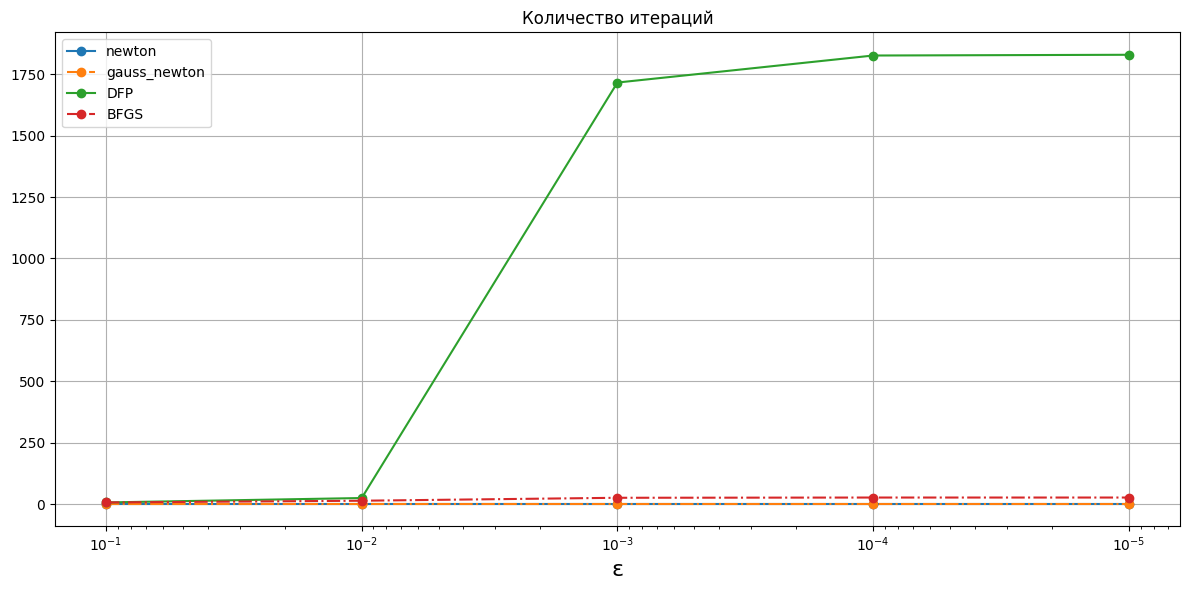

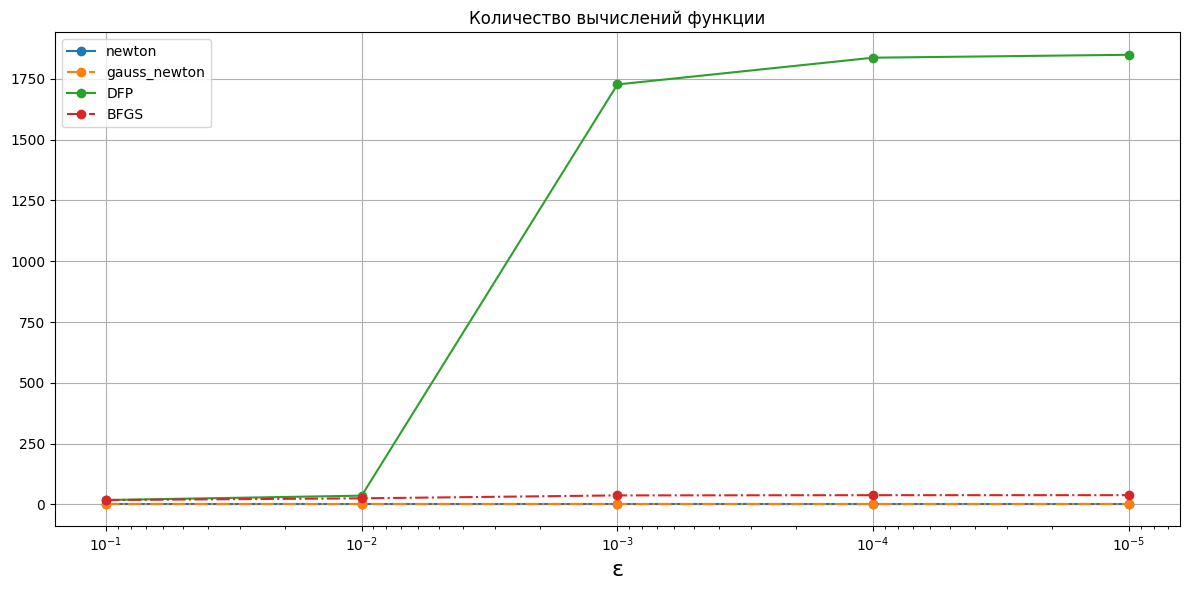

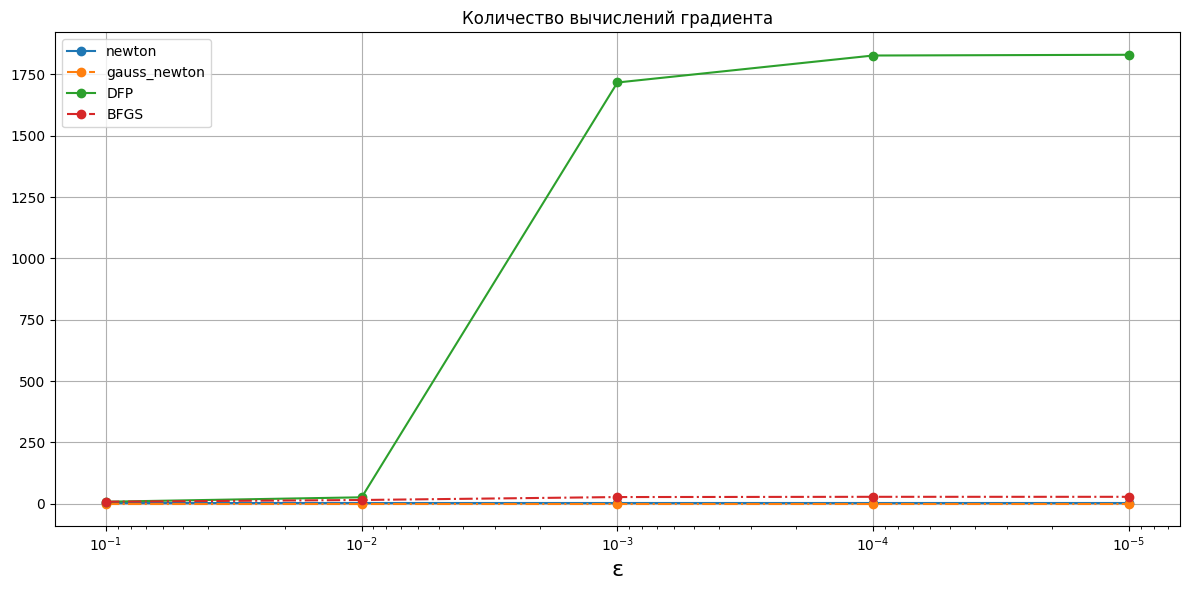

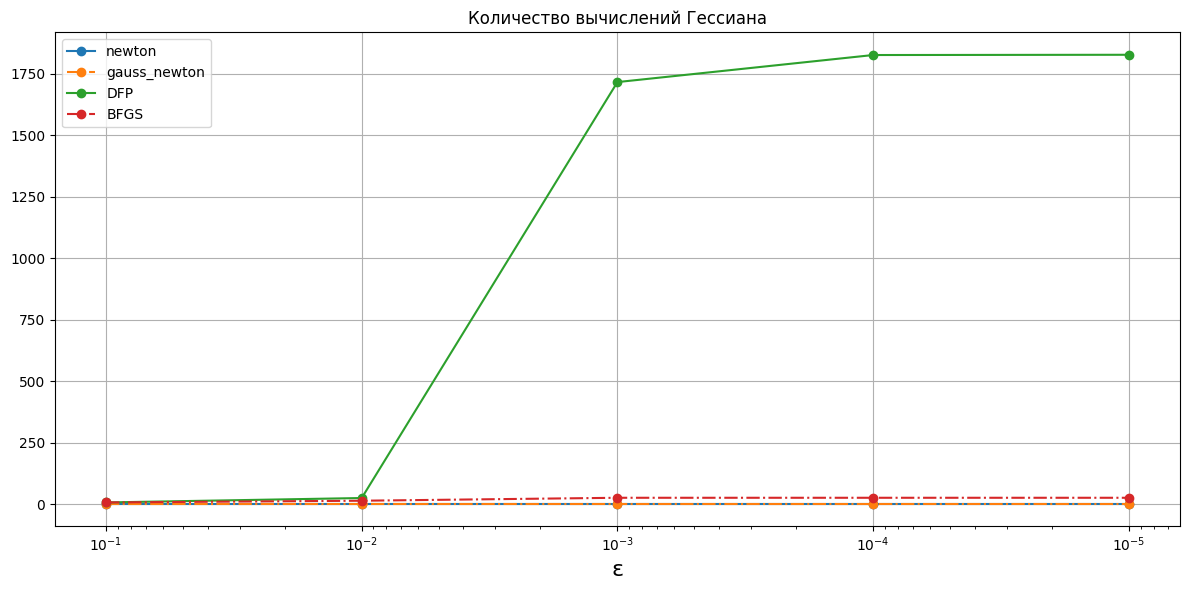

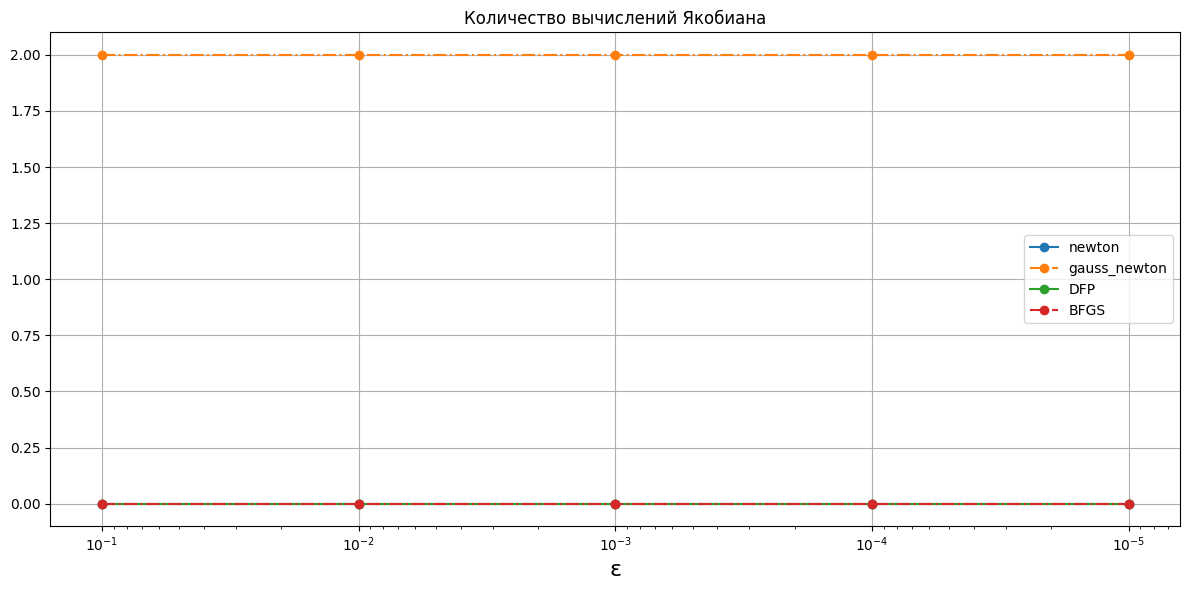

In [18]:
section_names = ['w_optim',
                'iter_number',
                'func_number',
                'grad_number',
                'hess_number',
                'jacob_number'
                ]

for ttl, tbl, file_name in zip(tbl_title[1:], tbl_list[1:], section_names[1:]):
    plt.figure(figsize=user_figsize)
    for mdx, meth in enumerate(col_name[1:]):
            plt.plot(
                    tbl['eps'],
                    tbl.iloc[:,1+mdx],
                    label=meth,
                    linestyle=line_style[mdx],
                    marker='.', markersize=user_markersize)
    plt.gca().invert_xaxis()
    plt.title(ttl)
    plt.grid()
    plt.legend()
    plt.xscale('log')
    plt.xlabel('\u03b5', fontsize=user_fontsize)
    plt.tight_layout()
    plt.savefig('readme_img/' + file_name + '.png', bbox_inches='tight')
    plt.show()

## Динамика функции потерь

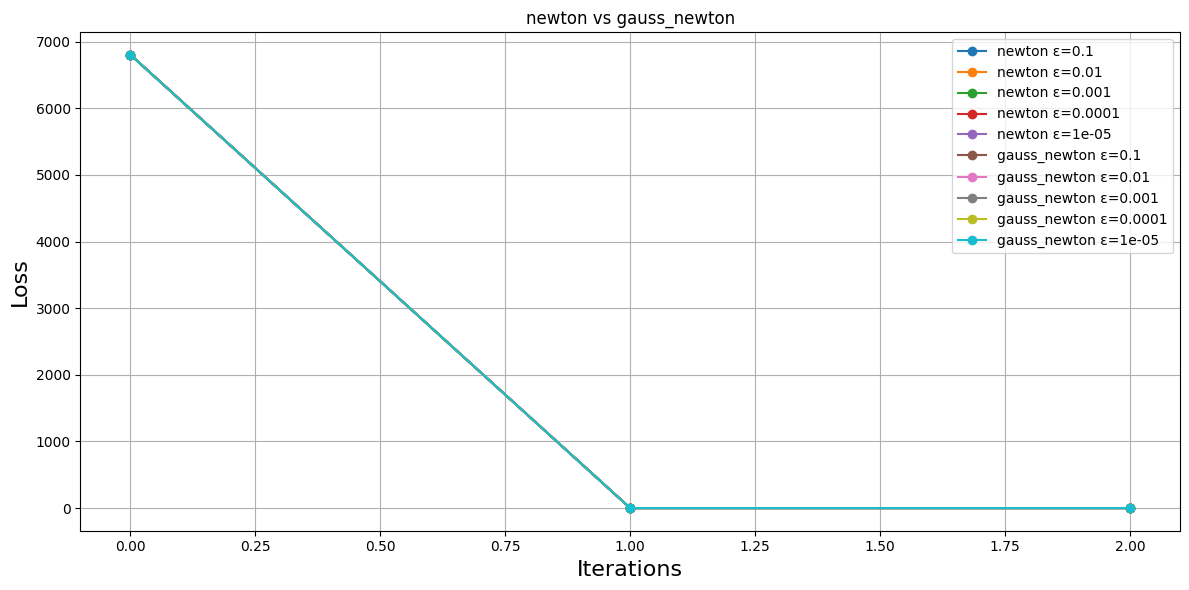

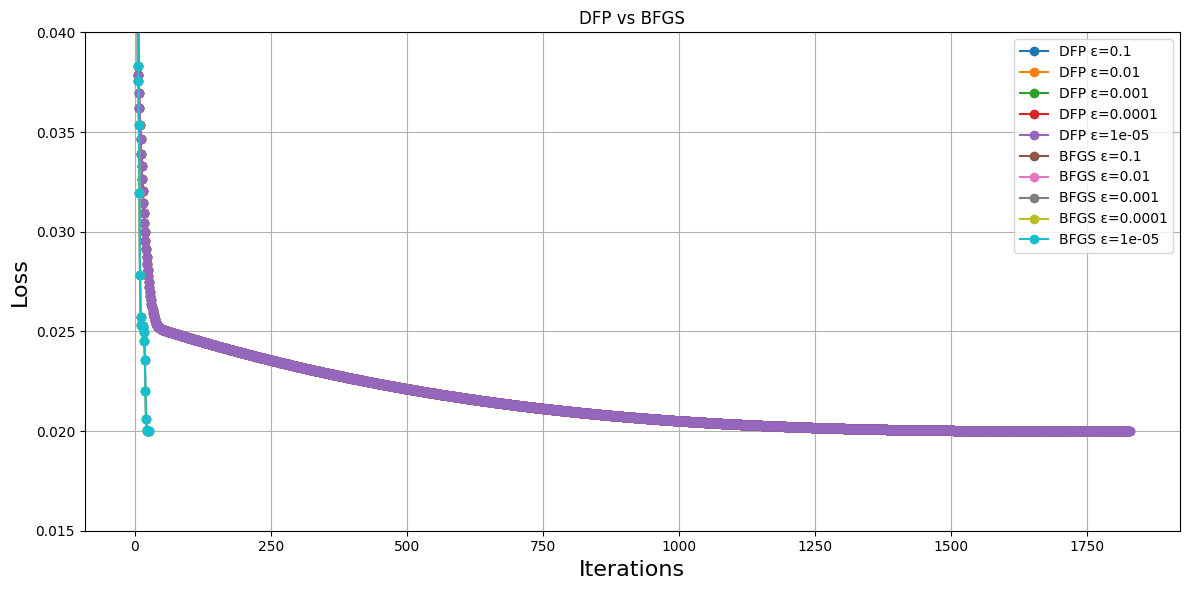

In [19]:
loss_groups = [losses_arr[:2], losses_arr[2:]]

for ndx, group in enumerate(loss_groups):
    plt.figure(figsize=user_figsize)    
    for mdx, loss_m in enumerate(group):
        for idx, loss_i in enumerate(loss_m):
            plt.plot(loss_i,
                    label=col_name[1+ndx*len(loss_groups)+mdx] + ' \u03b5=' + str(eps_var[idx]),
                    marker='.', markersize=user_markersize)
    if ndx == 1:
        plt.ylim(0.015,0.04)
    plt.title(col_name[1+ndx*len(loss_groups)] + ' vs ' + col_name[1+ndx*len(loss_groups) + 1])
    plt.grid()
    plt.legend()
    plt.ylabel('Loss', fontsize=user_fontsize)
    plt.xlabel('Iterations', fontsize=user_fontsize)
    plt.tight_layout()
    plt.savefig('readme_img/losses_' + col_name[1+ndx*len(loss_groups)] + '_vs_' + col_name[1+ndx*len(loss_groups) + 1] + '.png', bbox_inches='tight')
    plt.show()

## Предсказания

<function matplotlib.pyplot.show(close=None, block=None)>

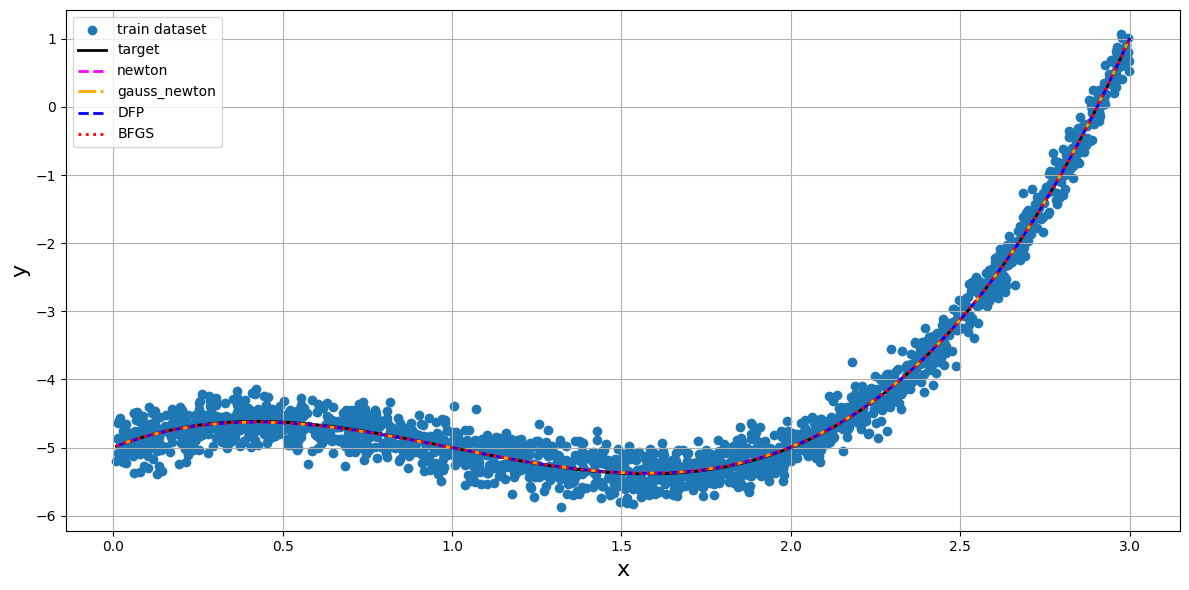

In [20]:
user_colors = [
    'black',
    'magenta',
    'orange',
    'blue',
    'red'
]
user_linestyle = ['-', '--', '-.', '--', ':']

plt.figure(figsize=user_figsize)
plt.scatter(X_train, y_train, label='train dataset')
for mdx, weights in enumerate(w_optim_tbl):
    plt.plot(np.sort(X_train),
             predict(X_train_vander_plt, weights),
             color=user_colors[mdx],
             linestyle=user_linestyle[mdx],
             linewidth=2,
             label=col_name_w_optim[mdx])# + ' trend line')
plt.legend()
plt.grid()
plt.xlabel('x', fontsize=user_fontsize)
plt.ylabel('y', fontsize=user_fontsize)
plt.tight_layout()
plt.savefig('readme_img/trend_line_plot.png', bbox_inches='tight')
plt.show

## Генератор таблиц в приложения

In [21]:
from functions.user_functions import update_readme_section

In [22]:
for tbl, ttl, section in zip(tbl_list, tbl_title, section_names):
    update_readme_section(tbl, readme_path='README.md', tbl_name=ttl, section=section)